<a href="https://colab.research.google.com/github/rafaelstankiewicz/ML-for-Air-Quality-Prediction/blob/main/LSTMPerformanceVersusTrainingTime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Rafael Stankiewicz

In [ ]:
import pandas as pd
import numpy as np
import pickle
import random
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import pylab
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, max_error, median_absolute_error, confusion_matrix 
from sklearn.inspection import PartialDependenceDisplay
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import metrics

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

cp = sns.color_palette("coolwarm", 12) + sns.color_palette("coolwarm_r", 12)
my_cmap = ListedColormap(sns.color_palette(cp).as_hex())

In [ ]:
!pip install colab-env

import os
import colab_env

#Rafael's Data Fetcher 
!wget https://raw.githubusercontent.com/rafaelstankiewicz/ML-for-Air-Quality-Prediction/main/data_fetcher.py
!wget https://raw.githubusercontent.com/rafaelstankiewicz/ML-for-Air-Quality-Prediction/main/preprocessing.py 

os.environ['EMAIL'] = " "
os.environ['KEY'] = " "

from data_fetcher import DataFetcher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colab-env: filename=colab_env-0.2.0-py3-none-any.whl size=3838 sha256=e993eb935f145dea35908f17cf392168610ea346a700be85766e85f641745c4e
  Stored in directory: /root/.cache/pip/wheels/bb/ca/e8/3d25b6abb4ac719ecb9e837bb75f2a9b980430005fb12a9107
Successfully built colab-env
Mounted at /content/gdrive
--2022-10-28 20:51:26--  https://raw.githubusercontent.com/osrussell/chem150/main/data_fetcher.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29770 (29K) [text/plain]
Saving to: ‘data_fetcher.py’

data_fetcher.py     100%[===================>]  29.07K  --.-KB/s    in 0.002s  

2022-10-28 20:51:27 (12.1 MB/s) - ‘data_fetcher.py’ saved [29770/2977

# Getting Data

We're using data from the Simi Valley-Cochran Street (west climate zone in CA)

state_code = 06

site_number = 2002

county_code = 111

Time range is the start of 2011 to end of 2017

In [ ]:
data_fetcher = DataFetcher()

In [ ]:
SVC_df = data_fetcher.create_dataset(20110101, 20171231, site='2002', county='111', state='06')

No data for Carbon monoxide
There is hourly data for PM2.5 - Local Conditions starting in the year 2013
No data for Ultraviolet radiation
No data for Barometric pressure


In [ ]:
# pickle_out = open("/content/gdrive/My Drive/ICAC/SVC_df.pickle","wb")
# pickle.dump(SVC_df, pickle_out)
# pickle_out.close()

pickle_in = open("/content/gdrive/Shared drives/FICUS_Lab/Data/dills_and_pickles/poster_Su22/SimiValleyDF_2011_2017.pickle","rb")
SVC_df = pickle.load(pickle_in)



In [ ]:
SVC_df

,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM2.5 - Local Conditions,Wind Direction - Resultant,Wind Speed - Resultant,Outdoor Temperature,Relative Humidity,Solar radiation,Carbon monoxide - qualifier,Nitrogen dioxide (NO2) - qualifier,Ozone - qualifier,PM2.5 - Local Conditions - qualifier,Wind Direction - Resultant - qualifier,Wind Speed - Resultant - qualifier,Outdoor Temperature - qualifier,Relative Humidity - qualifier,Solar radiation - qualifier
datetime,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,NaN,23.0,0.004,NaN,78.0,1.4,41.0,57.0,0.0,None,None,None,None,None,None,None,None,None
2011-01-01 01:00:00,NaN,NaN,NaN,NaN,108.0,1.6,40.0,58.0,0.0,None,BA - Maintenance/Routine Repairs.,BA - Maintenance/Routine Repairs.,None,None,None,None,None,None
2011-01-01 02:00:00,NaN,16.0,0.011,NaN,85.0,1.9,42.0,52.0,0.0,None,None,None,None,None,None,None,None,None
2011-01-01 03:00:00,NaN,14.0,0.010,NaN,129.0,1.2,42.0,54.0,0.0,None,None,None,None,None,None,None,None,None
2011-01-01 04:00:00,NaN,22.0,0.002,NaN,89.0,1.4,41.0,60.0,0.0,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,NaN,14.0,0.026,44.5,184.0,0.0,52.0,84.0,0.0,None,None,None,None,None,None,None,None,None
2017-12-31 20:00:00,NaN,21.0,0.012,42.5,92.0,1.2,50.0,85.0,0.0,None,None,None,None,None,None,None,None,None
2017-12-31 21:00:00,NaN,23.0,0.007,49.5,85.0,1.4,49.0,85.0,0.0,None,None,None,None,None,None,None,None,None


Now we want to make sure we're only training with the variables that we have for sure:

- NO2
- Ozone
- Wind Direction
- Wind Speed
- Outdoor Temperature
- Relative Humidity
- Solar Radiation

No Barometric Pressure in the df, and we don't want PM2.5

Therefore we're going to drop all our extra columns!!!

In [ ]:
# first, dropping all qualifiers
SVC_df = SVC_df.drop(SVC_df.columns[[9,10,11,12,13,14,15,16,17]], axis=1)
SVC_df

,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM2.5 - Local Conditions,Wind Direction - Resultant,Wind Speed - Resultant,Outdoor Temperature,Relative Humidity,Solar radiation
datetime,,,,,,,,,
2011-01-01 00:00:00,NaN,23.0,0.004,NaN,78.0,1.4,41.0,57.0,0.0
2011-01-01 01:00:00,NaN,NaN,NaN,NaN,108.0,1.6,40.0,58.0,0.0
2011-01-01 02:00:00,NaN,16.0,0.011,NaN,85.0,1.9,42.0,52.0,0.0
2011-01-01 03:00:00,NaN,14.0,0.010,NaN,129.0,1.2,42.0,54.0,0.0
2011-01-01 04:00:00,NaN,22.0,0.002,NaN,89.0,1.4,41.0,60.0,0.0
...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,NaN,14.0,0.026,44.5,184.0,0.0,52.0,84.0,0.0
2017-12-31 20:00:00,NaN,21.0,0.012,42.5,92.0,1.2,50.0,85.0,0.0
2017-12-31 21:00:00,NaN,23.0,0.007,49.5,85.0,1.4,49.0,85.0,0.0


In [ ]:
# now to narrow down
SVC_df = SVC_df.drop('PM2.5 - Local Conditions', axis=1)
SVC_df = SVC_df.drop('Carbon monoxide', axis=1)
SVC_df

,Nitrogen dioxide (NO2),Ozone,Wind Direction - Resultant,Wind Speed - Resultant,Outdoor Temperature,Relative Humidity,Solar radiation
datetime,,,,,,,
2011-01-01 00:00:00,23.0,0.004,78.0,1.4,41.0,57.0,0.0
2011-01-01 01:00:00,NaN,NaN,108.0,1.6,40.0,58.0,0.0
2011-01-01 02:00:00,16.0,0.011,85.0,1.9,42.0,52.0,0.0
2011-01-01 03:00:00,14.0,0.010,129.0,1.2,42.0,54.0,0.0
2011-01-01 04:00:00,22.0,0.002,89.0,1.4,41.0,60.0,0.0
...,...,...,...,...,...,...,...
2017-12-31 19:00:00,14.0,0.026,184.0,0.0,52.0,84.0,0.0
2017-12-31 20:00:00,21.0,0.012,92.0,1.2,50.0,85.0,0.0
2017-12-31 21:00:00,23.0,0.007,85.0,1.4,49.0,85.0,0.0


# Now to split the data!!! 

In [ ]:
SVC_df = SVC_df.interpolate()
SVC_df.isna().sum()

Nitrogen dioxide (NO2)        0
Ozone                         0
Wind Direction - Resultant    0
Wind Speed - Resultant        0
Outdoor Temperature           0
Relative Humidity             0
Solar radiation               0
dtype: int64

In [ ]:
n_steps = 24
SVC_df_norm=(SVC_df-SVC_df.min())/(SVC_df.max()-SVC_df.min())

# switching the location of the columns
B = SVC_df_norm.filter(['Ozone']) # just ozone
A = SVC_df_norm.drop(['Ozone'], axis=1) # everything but ozone
C = pd.merge(A, B, left_index=True, right_index=True) # everything but ozone + just ozone
SVC_df_np = C.to_numpy() # now in numpy format 

In [ ]:
def split_data(data_np, n_steps):
	"""
	Parameters:
		data_np: numpy version of the data 
		n_steps: steps fed to the LSTM????

	Returns
		X and Y np.arrays with the data split by the last value 
	"""
	X, y = list(), list() # making empty lists to store our X and y
	# for number of samples (ex: 43824)
	for i in range(len(data_np)):
		# kills loop if we are n_steps from the end of the total timesteps 
		end_ix = i + n_steps 
		if end_ix > len(data_np):
			break
    # this will reshape the data for input into the CNN
		# for data_x, appends times i to ix but without ozone
		# for data_np, appends last ozone 
		data_x, data_y = data_np[i:end_ix, :-1], data_np[end_ix-1, -1]
		X.append(data_x)
		y.append(data_y)
	return np.array(X), np.array(y)

In [ ]:
X_for_CNN, y_for_CNN = split_data(SVC_df_np, n_steps)

Now we want a 5 year / 2 year split for train and test!

This means we want len//7 * 5

In [ ]:
print(len(SVC_df))
print(len(X_for_CNN))

61368
61345


So we want

In [ ]:
# takes first 3rd of data for test 
seventh = len(SVC_df)//7
X_train_for_CNN = X_for_CNN[:seventh*5]
y_train_for_CNN = y_for_CNN[:seventh*5]
X_test_for_CNN = X_for_CNN[seventh*5:]
y_test_for_CNN = y_for_CNN[seventh*5:]

In [ ]:
pickle_out = open("/content/gdrive/My Drive/y_test_for_CNN.pickle","wb")
pickle.dump(y_test_for_CNN, pickle_out)
pickle_out.close()

# pickle_in = open("/content/gdrive/My Drive/ICAC/lstm_simivalley_prediction.pickle","rb")
# y_pred_for_LSTM = pickle.load(pickle_in)

Let's check when the first date is real fast!

In [ ]:
SVC_df[seventh*5:]

,Nitrogen dioxide (NO2),Ozone,Wind Direction - Resultant,Wind Speed - Resultant,Outdoor Temperature,Relative Humidity,Solar radiation
datetime,,,,,,,
2016-01-01 06:00:00,0.0,0.038,39.0,6.2,47.0,21.0,0.00
2016-01-01 07:00:00,0.0,0.038,38.0,7.8,47.0,21.0,0.05
2016-01-01 08:00:00,1.0,0.038,25.0,8.2,49.0,20.0,0.36
2016-01-01 09:00:00,1.0,0.038,17.0,8.9,50.0,19.0,0.60
2016-01-01 10:00:00,1.0,0.038,23.0,8.7,53.0,18.0,0.78
...,...,...,...,...,...,...,...
2017-12-31 19:00:00,14.0,0.026,184.0,0.0,52.0,84.0,0.00
2017-12-31 20:00:00,21.0,0.012,92.0,1.2,50.0,85.0,0.00
2017-12-31 21:00:00,23.0,0.007,85.0,1.4,49.0,85.0,0.00


In [ ]:
# the timestamp is shifted by a day (when n_steps = 24) because of how I set up the windowing
date_time_test_CNN = C.index[seventh*5 + n_steps - 1:] 

In [ ]:
pickle_out = open("/content/gdrive/My Drive/date_time_test_CNN.pickle","wb")
pickle.dump(date_time_test_CNN, pickle_out)
pickle_out.close()

# Actual model!!

In [ ]:
model_lstm_4 = Sequential()
model_lstm_4.add(LSTM(8, input_shape=(n_steps, SVC_df.shape[1]-1)))
model_lstm_4.add(Dense(1))
model_lstm_4.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.mean_squared_error])
history4 = model_lstm_4.fit(X_train_for_CNN, y_train_for_CNN, epochs=20, validation_split=0.2, batch_size=32, verbose=2)

Epoch 1/20
1096/1096 - 12s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 12s/epoch - 11ms/step
Epoch 2/20
1096/1096 - 5s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - 5s/epoch - 5ms/step
Epoch 3/20
1096/1096 - 5s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - 5s/epoch - 4ms/step
Epoch 4/20
1096/1096 - 5s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - 5s/epoch - 5ms/step
Epoch 5/20
1096/1096 - 5s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - 5s/epoch - 5ms/step
Epoch 6/20
1096/1096 - 5s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - 5s/epoch - 5ms/step
Epoch 7/20
1096/1096 - 5s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - 5s/epoch 

In [ ]:
# pickle_out = open("/content/gdrive/My Drive/ICAC/lstm_poster.pickle","wb")
# pickle.dump(model_lstm_4, pickle_out)
# pickle_out.close()

pickle_in = open("/content/gdrive/My Drive/lstm_CM_prediction.pickle","rb")
model_lstm_4 = pickle.load(pickle_in)

## Comparing Training Time vs. Model Performance

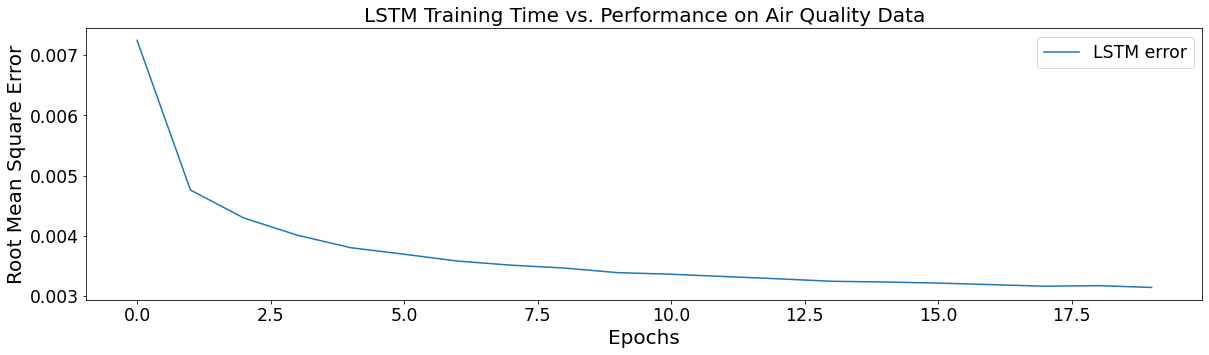

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(history4.epoch, history4.history["loss"], label="LSTM error")
ax.set_ylabel('Root Mean Square Error', size=20)
ax.set_xlabel('Epochs', size=20)
ax.legend()
ax.set_title('LSTM Training Time vs. Performance on Air Quality Data', fontsize=20)
plt.show()